# KLSE Advanced: Backtesting Trading Strategies

## Welcome!

This intermediate notebook teaches **backtesting** - testing trading strategies on historical Malaysian stock data.

### What You'll Learn:
1. Build backtesting framework
2. Test 3 trading strategies (MA Crossover, RSI, MACD)
3. Calculate performance metrics
4. Manage risk properly
5. Avoid common pitfalls

**Time:** 3-4 hours | **Level:** Intermediate | **Prerequisites:** KLSE Stock Screener notebook

**Disclaimer:** Educational purposes only. Past performance does not guarantee future results.

---

## 1. What is Backtesting?

**Backtesting** = Testing a trading strategy on past data to see if it would have worked.

### Why Backtest?
- Test ideas risk-free
- Compare strategies
- Build confidence
- Find weaknesses

### How It Works:
1. Define strategy rules
2. Get historical data
3. Simulate trades
4. Calculate results
5. Analyze performance

### Realistic Expectations:
- 10-15% annual: Good
- 15-20% annual: Very good
- 20%+: Excellent (but verify!)
- 50%+: Likely overfitted

### We'll Build:
1. MA Crossover Strategy
2. RSI Mean Reversion
3. MACD Momentum

---

## 2. Setup & Imports

Import libraries (same as beginner notebook):

In [1]:
# Data & Analysis
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Utilities
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
np.random.seed(42)

print('[OK] Libraries imported')
print(f'Today: {datetime.now().strftime("%Y-%m-%d")}')

[OK] Libraries imported
Today: 2025-11-13


## 3. Data & Framework

Build our backtesting foundation:

In [2]:
def get_data(ticker, start, end):
    '''Fetch historical data'''
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        
        # Fix MultiIndex columns issue
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
        
        if df.empty:
            print(f'No data for {ticker}')
            return None
        print(f'[OK] {len(df)} days for {ticker}')
        return df
    except Exception as e:
        print(f'Error: {e}')
        return None

# Test
test_df = get_data('1155.KL', '2021-01-01', '2023-12-31')
if test_df is not None:
    print(f'Data: {test_df.index[0].date()} to {test_df.index[-1].date()}')
    print(f'Columns: {list(test_df.columns)}')

[OK] 732 days for 1155.KL
Data: 2021-01-04 to 2023-12-29
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


In [3]:
def add_indicators(df):
    '''Add technical indicators'''
    df = df.copy()
    
    def safe(result):
        if result is None:
            return None
        if isinstance(result, pd.Series):
            return result
        if isinstance(result, pd.DataFrame):
            return result.iloc[:, 0] if len(result.columns) > 0 else None
        return result
    
    df['SMA_20'] = safe(df.ta.sma(20))
    df['SMA_50'] = safe(df.ta.sma(50))
    df['SMA_200'] = safe(df.ta.sma(200))
    df['RSI'] = safe(df.ta.rsi(14))
    
    macd = df.ta.macd()
    if macd is not None:
        df = pd.concat([df, macd], axis=1)
    
    return df

print('[OK] add_indicators() ready')

[OK] add_indicators() ready


## 4. Strategy #1: Moving Average Crossover

### Concept:
**BUY:** SMA-50 crosses above SMA-200 (Golden Cross)
**SELL:** SMA-50 crosses below SMA-200 (Death Cross)

### When it works:
- Strong trending markets
- Clear directional moves

### When it fails:
- Sideways/choppy markets
- Too many false signals

---

In [4]:
def ma_crossover(df):
    '''Generate MA crossover signals'''
    df = df.copy()
    df['Signal'] = 0
    df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1
    df['Position'] = df['Signal'].diff()
    return df

print('[OK] ma_crossover() strategy ready')

[OK] ma_crossover() strategy ready


In [5]:
def backtest(df, capital=100000, commission=0.001):
    '''Backtest strategy'''
    df = df.copy()
    
    # Returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)
    
    # Commission
    df['Commission'] = abs(df['Position']) * commission
    df['Strategy_Returns'] -= df['Commission']
    
    # Cumulative
    df['Cum_Market'] = (1 + df['Returns']).cumprod()
    df['Cum_Strategy'] = (1 + df['Strategy_Returns']).cumprod()
    
    # Portfolio value
    df['Portfolio'] = capital * df['Cum_Strategy']
    df['BuyHold'] = capital * df['Cum_Market']
    
    return df

print('[OK] backtest() engine ready')

[OK] backtest() engine ready


### Test MA Crossover on Maybank:

In [6]:
# Run backtest
df_may = get_data('1155.KL', '2021-01-01', '2023-12-31')

if df_may is not None:
    df_may = add_indicators(df_may)
    df_may = df_may.dropna()
    df_may = ma_crossover(df_may)
    df_may = backtest(df_may)
    
    buys = (df_may['Position'] == 1).sum()
    sells = (df_may['Position'] == -1).sum()
    
    final = df_may['Portfolio'].iloc[-1]
    bh = df_may['BuyHold'].iloc[-1]
    
    strat_ret = ((final / 100000) - 1) * 100
    bh_ret = ((bh / 100000) - 1) * 100
    
    print('='*60)
    print('MA CROSSOVER BACKTEST - MAYBANK')
    print('='*60)
    print(f'BUY signals: {buys}')
    print(f'SELL signals: {sells}')
    print(f'\nInitial: RM 100,000')
    print(f'Final: RM {final:,.2f}')
    print(f'Strategy Return: {strat_ret:+.2f}%')
    print(f'\nBuy & Hold: RM {bh:,.2f}')
    print(f'B&H Return: {bh_ret:+.2f}%')
    print(f'\nDifference: {strat_ret - bh_ret:+.2f}%')
    print('='*60)

[OK] 732 days for 1155.KL


MA CROSSOVER BACKTEST - MAYBANK
BUY signals: 0
SELL signals: 0

Initial: RM 100,000
Final: RM 124,969.81
Strategy Return: +24.97%

Buy & Hold: RM 124,969.81
B&H Return: +24.97%

Difference: +0.00%


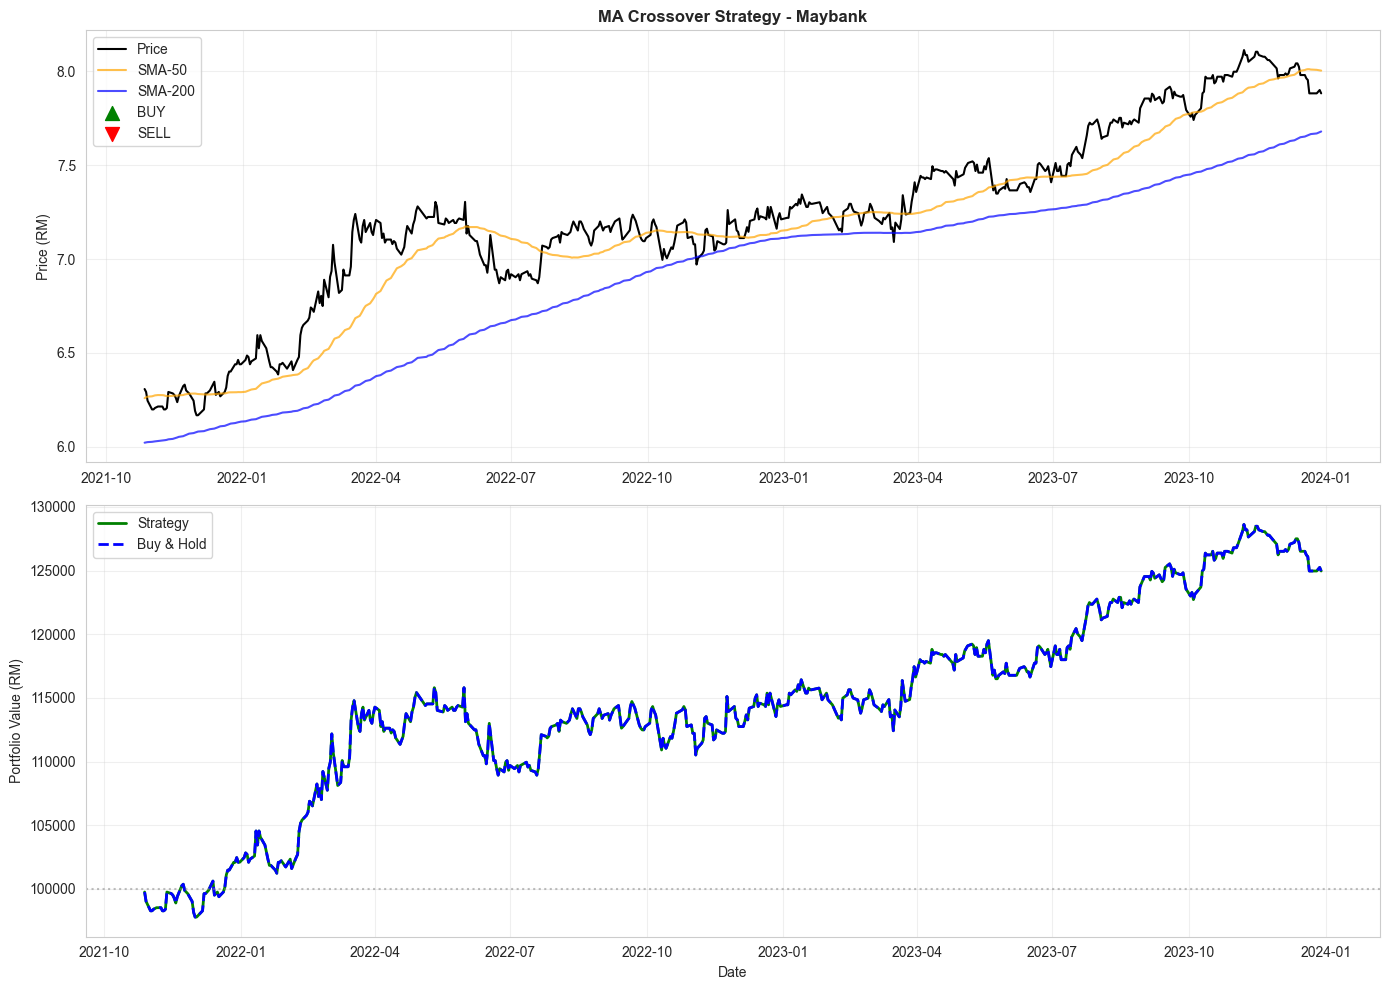

Green triangles = BUY | Red triangles = SELL


In [7]:
# Visualize results
if df_may is not None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Price & signals
    ax1.plot(df_may.index, df_may['Close'], 'k-', label='Price', lw=1.5)
    ax1.plot(df_may.index, df_may['SMA_50'], 'orange', label='SMA-50', alpha=0.7)
    ax1.plot(df_may.index, df_may['SMA_200'], 'blue', label='SMA-200', alpha=0.7)
    
    buys = df_may[df_may['Position'] == 1]
    sells = df_may[df_may['Position'] == -1]
    ax1.scatter(buys.index, buys['Close'], marker='^', c='g', s=100, label='BUY', zorder=5)
    ax1.scatter(sells.index, sells['Close'], marker='v', c='r', s=100, label='SELL', zorder=5)
    
    ax1.set_ylabel('Price (RM)')
    ax1.set_title('MA Crossover Strategy - Maybank', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Portfolio value
    ax2.plot(df_may.index, df_may['Portfolio'], 'g-', label='Strategy', lw=2)
    ax2.plot(df_may.index, df_may['BuyHold'], 'b--', label='Buy & Hold', lw=2)
    ax2.axhline(100000, color='gray', ls=':', alpha=0.5)
    
    ax2.set_ylabel('Portfolio Value (RM)')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('Green triangles = BUY | Red triangles = SELL')

## 5. Performance Metrics

Let's calculate proper performance metrics:

In [8]:
def calc_metrics(df, capital=100000):
    '''Calculate performance metrics'''
    returns = df['Strategy_Returns'].dropna()
    
    # Total return
    total_ret = ((df['Portfolio'].iloc[-1] / capital) - 1) * 100
    
    # CAGR
    days = (df.index[-1] - df.index[0]).days
    years = days / 365.25
    cagr = ((df['Portfolio'].iloc[-1] / capital) ** (1/years) - 1) * 100
    
    # Sharpe (assuming 3% risk-free)
    excess = returns - (0.03/252)
    sharpe = np.sqrt(252) * excess.mean() / returns.std()
    
    # Max Drawdown
    cummax = df['Portfolio'].cummax()
    dd = (df['Portfolio'] - cummax) / cummax
    max_dd = dd.min() * 100
    
    # Win rate
    wins = (returns > 0).sum()
    total = len(returns[returns != 0])
    win_rate = (wins / total * 100) if total > 0 else 0
    
    return {
        'Total Return (%)': round(total_ret, 2),
        'CAGR (%)': round(cagr, 2),
        'Sharpe Ratio': round(sharpe, 2),
        'Max Drawdown (%)': round(max_dd, 2),
        'Win Rate (%)': round(win_rate, 2),
        'Total Trades': int(total)
    }

print('[OK] calc_metrics() ready')

[OK] calc_metrics() ready


In [9]:
# Calculate metrics for Maybank MA strategy
if df_may is not None:
    metrics = calc_metrics(df_may)
    
    print('='*50)
    print('PERFORMANCE METRICS - MA CROSSOVER')
    print('='*50)
    for key, val in metrics.items():
        print(f'{key:<25}: {val}')
    print('='*50)
    
    print('\nInterpretation:')
    if metrics['Sharpe Ratio'] > 1:
        print('[OK] Sharpe > 1: Good risk-adjusted returns')
    else:
        print('[WARNING] Sharpe < 1: Poor risk-adjusted returns')
    
    if abs(metrics['Max Drawdown (%)']) < 20:
        print('[OK] Drawdown < 20%: Acceptable risk')
    else:
        print('[WARNING] Drawdown > 20%: High risk')

PERFORMANCE METRICS - MA CROSSOVER
Total Return (%)         : 24.97
CAGR (%)                 : 10.81
Sharpe Ratio             : 0.81
Max Drawdown (%)         : -5.93
Win Rate (%)             : 53.16
Total Trades             : 474

Interpretation:
[WARNING] Sharpe < 1: Poor risk-adjusted returns
[OK] Drawdown < 20%: Acceptable risk


## 6. Strategy #2: RSI Mean Reversion

### Concept:
**BUY:** RSI < 30 (oversold)
**SELL:** RSI > 70 (overbought)

### Logic:
When price drops too much (RSI < 30), it tends to bounce back.
When price rises too much (RSI > 70), it tends to pull back.

---

In [10]:
def rsi_strategy(df):
    '''RSI mean reversion strategy'''
    df = df.copy()
    df['Signal'] = 0
    
    # Buy when oversold, sell when overbought
    df.loc[df['RSI'] < 30, 'Signal'] = 1
    df.loc[df['RSI'] > 70, 'Signal'] = 0
    
    # Forward fill (hold position until next signal)
    df['Signal'] = df['Signal'].replace(0, np.nan).ffill().fillna(0)
    df['Position'] = df['Signal'].diff()
    
    return df

print('[OK] rsi_strategy() ready')

[OK] rsi_strategy() ready


In [11]:
# Test RSI strategy on Maybank
df_rsi = get_data('1155.KL', '2021-01-01', '2023-12-31')

if df_rsi is not None:
    df_rsi = add_indicators(df_rsi)
    df_rsi = df_rsi.dropna()
    df_rsi = rsi_strategy(df_rsi)
    df_rsi = backtest(df_rsi)
    
    metrics_rsi = calc_metrics(df_rsi)
    
    print('='*50)
    print('RSI MEAN REVERSION - MAYBANK')
    print('='*50)
    for k, v in metrics_rsi.items():
        print(f'{k:<25}: {v}')
    print('='*50)

[OK] 732 days for 1155.KL
RSI MEAN REVERSION - MAYBANK
Total Return (%)         : -0.1
CAGR (%)                 : -0.05
Sharpe Ratio             : -15.11
Max Drawdown (%)         : -0.22
Win Rate (%)             : 50.0
Total Trades             : 4


## 7. Strategy #3: MACD Momentum

### Concept:
**BUY:** MACD crosses above signal line
**SELL:** MACD crosses below signal line

---

In [12]:
def macd_strategy(df):
    '''MACD momentum strategy'''
    df = df.copy()
    df['Signal'] = 0
    
    if 'MACD_12_26_9' in df.columns and 'MACDs_12_26_9' in df.columns:
        df.loc[df['MACD_12_26_9'] > df['MACDs_12_26_9'], 'Signal'] = 1
        df['Position'] = df['Signal'].diff()
    
    return df

print('[OK] macd_strategy() ready')

[OK] macd_strategy() ready


In [13]:
# Test MACD strategy
df_macd = get_data('1155.KL', '2021-01-01', '2023-12-31')

if df_macd is not None:
    df_macd = add_indicators(df_macd)
    df_macd = df_macd.dropna()
    df_macd = macd_strategy(df_macd)
    df_macd = backtest(df_macd)
    
    metrics_macd = calc_metrics(df_macd)
    
    print('='*50)
    print('MACD MOMENTUM - MAYBANK')
    print('='*50)
    for k, v in metrics_macd.items():
        print(f'{k:<25}: {v}')
    print('='*50)

[OK] 732 days for 1155.KL
MACD MOMENTUM - MAYBANK
Total Return (%)         : -2.25
CAGR (%)                 : -1.04
Sharpe Ratio             : -0.52
Max Drawdown (%)         : -13.24
Win Rate (%)             : 44.79
Total Trades             : 259


## 8. Risk Management

### Stop-Loss Implementation
Limit losses by exiting when price drops X%:

---

In [14]:
def add_stop_loss(df, stop_pct=0.05):
    '''Add stop-loss (5% default)'''
    df = df.copy()
    entry_price = None
    
    for i in range(len(df)):
        if df['Position'].iloc[i] == 1:  # Entry
            entry_price = df['Close'].iloc[i]
        elif entry_price is not None and df['Signal'].iloc[i] == 1:
            # Check stop-loss
            if df['Close'].iloc[i] < entry_price * (1 - stop_pct):
                df.loc[df.index[i], 'Signal'] = 0
                df.loc[df.index[i], 'Position'] = -1
                entry_price = None
        elif df['Position'].iloc[i] == -1:
            entry_price = None
    
    return df

print('[OK] add_stop_loss() ready')
print('Adds 5% stop-loss to protect capital')

[OK] add_stop_loss() ready
Adds 5% stop-loss to protect capital


## 9. Multi-Stock Portfolio

Test strategy across multiple Malaysian stocks:

---

In [15]:
# Test MA Crossover on 5 stocks
stocks = ['1155.KL', '1295.KL', '1023.KL', '5296.KL', '4197.KL']
names = ['Maybank', 'PublicBank', 'CIMB', 'Tenaga', 'Maxis']

results = []

for ticker, name in zip(stocks, names):
    print(f'Testing {name}...')
    df = get_data(ticker, '2021-01-01', '2023-12-31')
    if df is not None:
        df = add_indicators(df)
        df = df.dropna()
        df = ma_crossover(df)
        df = backtest(df)
        m = calc_metrics(df)
        m['Stock'] = name
        results.append(m)

# Show results
import pandas as pd
results_df = pd.DataFrame(results)
print('\n' + '='*70)
print('MA CROSSOVER - PORTFOLIO RESULTS')
print('='*70)
print(results_df.to_string(index=False))
print('='*70)

Testing Maybank...


[OK] 732 days for 1155.KL


Testing PublicBank...


[OK] 732 days for 1295.KL
Testing CIMB...


[OK] 732 days for 1023.KL
Testing Tenaga...


[OK] 732 days for 5296.KL
Testing Maxis...


[OK] 732 days for 4197.KL

MA CROSSOVER - PORTFOLIO RESULTS
 Total Return (%)  CAGR (%)  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Total Trades      Stock
            24.97     10.81          0.81             -5.93         53.16           474    Maybank
             7.76      3.50          0.10            -11.25         50.37           268 PublicBank
             2.10      0.96         -0.04            -16.81         51.51           365       CIMB
            -4.59     -2.14         -1.49             -5.57         43.75            16     Tenaga
            -1.33     -0.62         -0.13            -19.61         46.96           313      Maxis


## 10. Common Pitfalls

### 1. Overfitting
Making strategy work TOO well on past data

### 2. Look-ahead Bias
Using future information

### 3. Ignoring Costs
Forgetting commissions and slippage

### 4. Survivorship Bias
Only testing stocks that still exist

**How to avoid:** Use out-of-sample testing, realistic costs, and diverse data

---

## 11. Strategy Comparison

Compare all 3 strategies:

---

In [16]:
# Compare strategies on Maybank
comparison = [
    {'Strategy': 'MA Crossover', **metrics},
    {'Strategy': 'RSI Mean Reversion', **metrics_rsi},
    {'Strategy': 'MACD Momentum', **metrics_macd}
]

comp_df = pd.DataFrame(comparison)
print('='*70)
print('STRATEGY COMPARISON - MAYBANK (2021-2023)')
print('='*70)
print(comp_df.to_string(index=False))
print('='*70)

# Find best
best_idx = comp_df['CAGR (%)'].idxmax()
print(f'\n[WINNER] {comp_df.loc[best_idx, "Strategy"]}')
print(f'Best CAGR: {comp_df.loc[best_idx, "CAGR (%)"]:.2f}%')

STRATEGY COMPARISON - MAYBANK (2021-2023)
          Strategy  Total Return (%)  CAGR (%)  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Total Trades
      MA Crossover             24.97     10.81          0.81             -5.93         53.16           474
RSI Mean Reversion             -0.10     -0.05        -15.11             -0.22         50.00             4
     MACD Momentum             -2.25     -1.04         -0.52            -13.24         44.79           259

[WINNER] MA Crossover
Best CAGR: 10.81%


## 12. Next Steps

### Congratulations!

You've learned:
- How to backtest strategies
- Build MA, RSI, and MACD strategies
- Calculate performance metrics
- Manage risk
- Avoid common mistakes

### Advanced Topics:
1. **Machine Learning** - Use ML to optimize strategies
2. **Walk-Forward Testing** - More robust validation
3. **Portfolio Optimization** - Modern Portfolio Theory
4. **Options Strategies** - Hedging and income
5. **Live Trading** - Deploy with proper risk management

### Practice Exercises:
1. Test strategies on different timeframes
2. Combine multiple indicators
3. Optimize parameters (MA lengths, RSI levels)
4. Add position sizing rules
5. Test on different market conditions

### Resources:
- "Evidence-Based Technical Analysis" - David Aronson
- "Algorithmic Trading" - Ernest Chan
- QuantStart.com - Free education
- Backtrader library - Advanced backtesting

**Remember:** Always paper trade before using real money!

---

## Thank You!

Happy backtesting! May your strategies be profitable and your drawdowns minimal. 📈